In [30]:
import os
import sys
import time#data = pystan.read_rdump('data.R')
import numpy as np
from numpy import *
from pylab import *
from scipy import *
from matplotlib.pyplot import *
import matplotlib.pyplot as plt


import pystan

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [32]:
%pylab inline
#%matplotlib notebook
plt.style.use('seaborn-talk');

Populating the interactive namespace from numpy and matplotlib


/home/meysam/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log10', 'power', 'arctanh', 'test', '__version__', 'show_config', 'draw_if_interactive', 'arcsin', 'arccos', 'log2', 'linalg', 'sqrt', 'log', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In this toy example, we first generate a synthetic data  using a second-order polynomial and we then fit different models  (polynomials order 1,2, 3, and 5) in order to see which model best explains the generated data.

# Generate Synthetic Data

In [33]:
a = 5
b = 3
c=2
sigma=1
random.seed(11442)
noise =sigma * randn() 

In [34]:
nt = 100
t = linspace(-5, 5, nt)
y = a*(t**2)+b*t+c

yobs = yobs = y+sigma*randn(y.size)

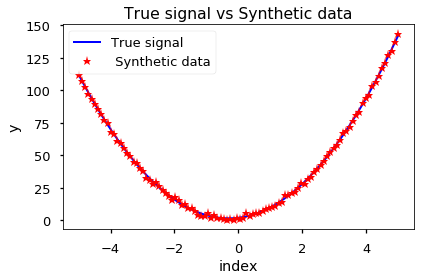

In [35]:
figure(figsize=(6, 4))

plot(t,y, color='b', linewidth=2.0, label='True signal')
plot(t, yobs,'r*', label=' Synthetic data' )

xlabel("index")
ylabel("y")
title('True signal vs Synthetic data')
legend()
tight_layout()
show() 



# Save Data to run Stan

In [36]:
data_input= {'nt': nt, 't': t, 'yobs': yobs}


nd=[]
npz = {'nd': nd}
npz.update(data_input)

savez('data_input.npz', **npz)
savez('data_input.R.npz', **npz)
pystan.stan_rdump(data_input, 'data_input.R')

In [37]:
data_input = dict(load('data_input.R.npz'))

#data = pystan.read_rdump('data.R')

# Generate SweepData for Stan

In [38]:
cwd = os.getcwd()
cwd

'/home/meysam/WorkLinux/PolynomialModelComparision/BestPolynomialDegree'

In [39]:
ndegree=0.0

In [40]:
data_dict= {'nt': nt, 'ndegree': ndegree, 't': t, 'yobs': yobs}


nd=[]
npz = {'nd': nd}
npz.update(data_dict)

savez('data_input.npz', **npz)
savez('data_input.R.npz', **npz)
pystan.stan_rdump(data_dict, 'data_input.R')

In [41]:
filename = "data_input"

if filename in os.listdir(cwd):
    print('Directory Exists')
        
if not os.path.exists(os.path.join(cwd, filename)):
    try:
        os.mkdir(os.path.join(cwd, filename))
    except OSError as exception: 
        if exception.errno != errno.EEXIST:
            raise

In [42]:
cwd_datainput= os.path.join(cwd, filename)

In [43]:
npz.update(data_dict)

ndegree=array([1, 2, 3, 5])


idx_R=0
for i in range(1,len(ndegree)+1):
                npz.update({"ndegree":  ndegree [i-1]})
                idx_R= idx_R+1
                "data_input" + str(idx_R) + ".R.npz"
                "data_input%s.R.npz" % idx_R
                file_name_npz="data_input{}.npz".format(idx_R)
                savez(os.path.join(cwd_datainput, file_name_npz), **npz)
                
                file_name_Rnpz="data_input{}.R.npz".format(idx_R)
                savez(os.path.join(cwd_datainput, file_name_Rnpz), **npz)
                
                file_name_R="data_input{}.R".format(idx_R)
                os.chdir(cwd_datainput)
                pystan.stan_rdump( npz, file_name_R)
  

In [44]:
%cd ..

/home/meysam/WorkLinux/PolynomialModelComparision/BestPolynomialDegree


# Measuring information criteria 

In [69]:
%%bash

iter=2000
alg="hmc"

model="model_polynomial"

mkdir -p  data_output_${model}

N=4

for ((i = 1; i <= N; i++));
do
    echo "Running data_input"$i

    for j in `seq 4`
    do       
            echo "chain"$j "for data_input"$i

            python RunStan4IC.py data_input/data_input$i.npz ${model}.stan  ${alg} ${iter} data_output_${model}/output_${model}_$i-$j.npz 
   
   done
  
done

 
python ComputeIC_Hypos.py data_input.npz ${model}.stan data_output_${model}/output*.npz 
        
python ComputePSIS_Hypos.py data_input.npz ${model}.stan data_output_${model}/output*.npz 


Running data_input1
chain1 for data_input1

Gradient evaluation took 3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  500 / 2000 [ 25%]  (Warmup)
Iteration:  501 / 2000 [ 25%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Sampling)
Iteration: 1500 / 2000 [ 75%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.238574 seconds (Warm-up)
               0.256816 seconds (Sampling)
               0.49539 seconds (Total)

..............................................
creating model ...
creating model done.
loading data ...
sampling ...
saving...
..............................................
chain2 for data_input1

Gradient evaluation took 2.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  500 / 2000 

# Plot information criteria

Lets see what we have in the current dir!

In [70]:
import re
import glob
from operator import itemgetter

cwd = os.getcwd()
os.chdir(cwd)

numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [71]:
allNpzFiles = sorted(glob.glob(cwd + "/*.npz"), key=numericalSort)

allNpzFiles

['/home/meysam/WorkLinux/PolynomialModelComparision/BestPolynomialDegree/Outfile_PSIS_model_polynomial.npz',
 '/home/meysam/WorkLinux/PolynomialModelComparision/BestPolynomialDegree/Outfile_WAIC_model_polynomial.npz',
 '/home/meysam/WorkLinux/PolynomialModelComparision/BestPolynomialDegree/data_input.R.npz',
 '/home/meysam/WorkLinux/PolynomialModelComparision/BestPolynomialDegree/data_input.npz']

In [72]:
Outputfiles= [x.rsplit('/')[-1].rsplit('.npz')[-2] for x in allNpzFiles if "Outfile" in x]
Outputfiles

['Outfile_PSIS_model_polynomial', 'Outfile_WAIC_model_polynomial']

In [73]:
Outfile_WAIC=[]
Outfile_PSIS=[]

elpd_waic_values=[]
p_waic_values=[]
loo_values=[]

for file in Outputfiles:
      if "WAIC" in file:
            Outfile_WAIC.append(file)
            npz=load(str(file)+'.npz')
            elpd_waic=npz['elpd_waic_values']
            p_waic=npz['p_waic_values']
            elpd_waic_values.append(elpd_waic)
            p_waic_values.append(p_waic)

      if "PSIS" in file:
            Outfile_PSIS.append(file)
            npz=load(str(file)+'.npz')
            loo=npz['loo_values']
            loo_values.append(loo)

In [74]:
waic_values = [i * -2 for i in elpd_waic_values]

In [81]:
elpd_waic_values=asarray(elpd_waic_values)
p_waic_values=asarray(p_waic_values)
waic_values=asarray(waic_values)
loo_values=asarray(loo_values)

In [82]:
p_waic_values

array([[ 2.9648593 ,  2.88401933,  3.15874992,  3.00843344,  3.52568773,
         3.89247924,  3.61834495,  3.85689985,  4.58260532,  4.53812994,
         4.38857099,  4.50316654,  6.19050122,  6.12550123,  6.3077352 ,
         6.36369449]])

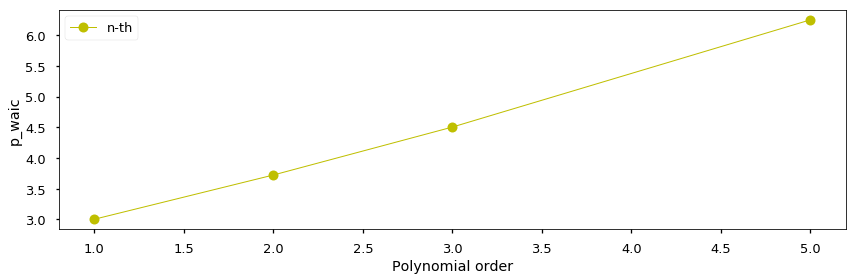

In [101]:
x=ndegree
y=p_waic_values

figure(figsize=(12, 4))
for i in range((y.shape[0])):
        subplot(1, (y.shape[0]), i + 1)  
        plot(x, mean(y[i,:].reshape(-1, 4), axis=1),  'y',  linewidth=1.0, marker='o', markersize=10, fillstyle='full', label='n-th')
        xlabel("Polynomial order")
        ylabel("p_waic")
        legend()
tight_layout()
show()   


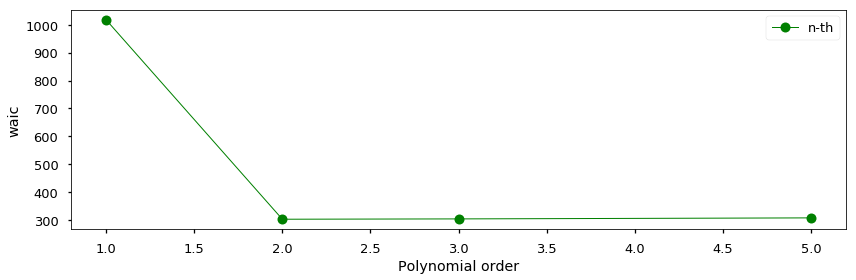

In [104]:
x=ndegree
y=waic_values

figure(figsize=(12, 4))
for i in range((y.shape[0])):
        subplot(1, (y.shape[0]), i + 1)  
        plot(x, mean(y[i,:].reshape(-1, 4), axis=1),  'g',  linewidth=1.0, marker='o', markersize=10, fillstyle='full', label='n-th')
        xlabel("Polynomial order")
        ylabel("waic")
        legend()
tight_layout()
show()   


In [93]:
bestmodel_idx=argmin(mean(waic_values[i,:].reshape(-1, 4), axis=1))

In [95]:
print('The order of best polynomial fitted to data is:', ndegree[bestmodel_idx])

The order of best polynomial fitted to data is: 2


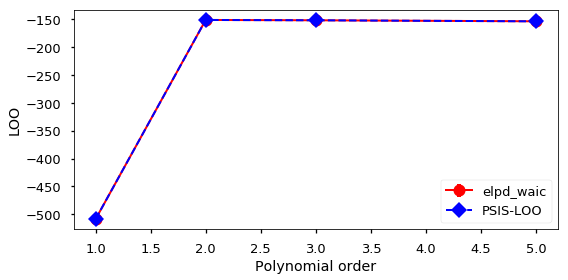

In [88]:
x=ndegree
y=waic_values

figure(figsize=(8, 4))
for i in range((y.shape[0])):
        #plot(x,mean(y[i,:].reshape(-1, 4), axis=1),  'r',  linewidth=4.0, marker='o', markersize=10, fillstyle='none', label='elpd_waic')
        #plot(x,mean(loo_values[i,:].reshape(-1, 4), axis=1),  'b--',  linewidth=2.0, marker='D', markersize=6, fillstyle='full', label='PSIS-LOO')
        errorbar(x, mean(elpd_waic_values[i,:].reshape(-1, 4), axis=1), yerr=std(elpd_waic_values[i,:].reshape(-1, 4), axis=1),
        elinewidth=4, ecolor='r',  linestyle='-', linewidth=2.0, fmt='r',
        marker='o',markersize=12,  mfc='r',  mec='red', label='elpd_waic')
        
        errorbar(x, mean(loo_values[i,:].reshape(-1, 4), axis=1), yerr=std(loo_values[i,:].reshape(-1, 4), axis=1),
        elinewidth=2, ecolor='b',  linestyle='--', linewidth=2.0, fmt='b',
        marker='D',markersize=12,  mfc='b',  mec='b', label='PSIS-LOO')
            
        xlabel("Polynomial order")
        ylabel("LOO")
        legend()
tight_layout()
show()   
